<a href="https://colab.research.google.com/github/mrlocastellani/pamap2/blob/main/pamap2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from google.colab import drive
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, precision_recall_curve, auc
import seaborn as sns
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


# Data Importing and Formatting

In [ ]:
list_of_files = [r"/content/drive/MyDrive/ColabData/Protocol/subject101.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject102.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject103.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject104.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject105.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject106.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject107.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject108.dat",
                 r"/content/drive/MyDrive/ColabData/Protocol/subject109.dat"]

subjectID = [1,2,3,4,5,6,7,8,9]

activityIDdict = {0: 'transient',
                  1: 'lying',
                  2: 'sitting',
                  3: 'standing',
                  4: 'walking',
                  5: 'running',
                  6: 'cycling',
                  7: 'Nordic_walking',
                  9: 'watching_TV',
                  10: 'computer_work',
                  11: 'car driving',
                  12: 'ascending_stairs',
                  13: 'descending_stairs',
                  16: 'vacuum_cleaning',
                  17: 'ironing',
                  18: 'folding_laundry',
                  19: 'house_cleaning',
                  20: 'playing_soccer',
                  24: 'rope_jumping' }

colNames = ["timestamp", "activityID","heartrate"]

IMUhand = ['handTemperature',
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3',
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3',
           'handGyro1', 'handGyro2', 'handGyro3',
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMUchest = ['chestTemperature',
            'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3',
            'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3',
            'chestGyro1', 'chestGyro2', 'chestGyro3',
            'chestMagne1', 'chestMagne2', 'chestMagne3',
            'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMUankle = ['ankleTemperature',
            'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3',
            'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3',
            'ankleGyro1', 'ankleGyro2', 'ankleGyro3',
            'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
            'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

columns = colNames + IMUhand + IMUchest + IMUankle

In [ ]:
dataCollection = pd.DataFrame()
for file in list_of_files:
    procData = pd.read_table(file, header=None, sep='\s+')
    procData.columns = columns
    procData['subject_id'] = int(file[-5])
    dataCollection = pd.concat([dataCollection, procData], ignore_index=True)

dataCollection.reset_index(drop=True, inplace=True)
dataCollection.head()

In [ ]:
def dataCleaning(dataCollection):
        dataCollection = dataCollection.drop(['handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4',
                                             'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4',
                                             'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4'],
                                             axis = 1)  # removal of orientation columns according to the readme
        dataCollection = dataCollection.drop(dataCollection[dataCollection.activityID == 0].index) #removal of any row of activity 0 as it is transient activity which it is not used
        dataCollection = dataCollection.apply(pd.to_numeric, errors = 'coerce') #removal of non numeric data in cells
        dataCollection = dataCollection.interpolate() #removal of any remaining NaN value cells by constructing new data points in known set of data points

        return dataCollection

In [ ]:
dataCol = dataCleaning(dataCollection)
dataCol.reset_index(drop = True, inplace = True)
dataCol.head(10)

In [ ]:
for i in range(0, 4):
    dataCol.loc[:3, "heartrate"] = 100

In [ ]:
dataCol.to_csv('/content/drive/MyDrive/ColabData/pamap_data_collection.csv', index=False)

In [3]:
dataCollection = pd.read_csv('/content/drive/MyDrive/ColabData/pamap_data_collection.csv')

In [4]:
valid_activity_ids = [1, 2, 3, 4, 16, 17]

data = dataCollection[dataCollection['activityID'].isin(valid_activity_ids)].copy()

label_encoder = LabelEncoder()

data['activityID'] = label_encoder.fit_transform(data['activityID'])

feature_columns = ['heartrate', 'handTemperature',
       'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 'handGyro1', 'handGyro2', 'handGyro3', 'handMagne1',
       'handMagne2', 'handMagne3', 'chestTemperature', 'chestAcc16_1',
       'chestAcc16_2', 'chestAcc16_3',  'chestGyro1', 'chestGyro2', 'chestGyro3', 'chestMagne1',
       'chestMagne2', 'chestMagne3', 'ankleTemperature', 'ankleAcc16_1',
       'ankleAcc16_2', 'ankleAcc16_3', 'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 'ankleMagne1',
       'ankleMagne2', 'ankleMagne3', 'subject_id']

label_column = 'activityID'

# Model Configuration Selection
In this section, we prepared a logic to choosing specific values for the model hyperparameters, including 'filters', 'size', 'pool_size', and 'dense_neurons'. The objective is to find a configuration that yields the best validation accuracy.


In [7]:
all_subjects = data['subject_id'].unique()
np.random.shuffle(all_subjects)

num_test_subjects = 2
subjects_to_test = all_subjects[:num_test_subjects]

mask = data['subject_id'].isin(subjects_to_test)
data_to_test = data[mask].copy()
data_to_train = data[~mask].copy()

In [ ]:
X_train = data_to_train[feature_columns].values
y_train = data_to_train[label_column].values

X_test = data_to_test[feature_columns].values
y_test = data_to_test[label_column].values

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

num_filters = [64, 128]
filter_sizes = [3, 5, 7]
pool_sizes = [2, 3]
num_dense_neurons = [64, 128]

best_val_accuracy = 0
best_model_config = {}

for filters in num_filters:
    for size in filter_sizes:
        for pool_size in pool_sizes:
            for dense_neurons in num_dense_neurons:
                model = Sequential()
                model.add(Conv1D(filters, size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
                model.add(MaxPooling1D(pool_size))
                model.add(Conv1D(filters, size, activation='relu'))
                model.add(MaxPooling1D(pool_size))
                model.add(GlobalMaxPooling1D())
                model.add(Dense(dense_neurons, activation='relu'))
                model.add(Dropout(0.5))
                model.add(Dense(6, activation='softmax'))

                model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

                early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

                history = model.fit(X_train, y_train_one_hot, epochs=50, batch_size=32, validation_data=(X_test, y_test_one_hot), callbacks=[early_stop])

                _, val_accuracy = model.evaluate(X_test, y_test_one_hot)

                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    best_model_config = {
                        'filters': filters,
                        'size': size,
                        'pool_size': pool_size,
                        'dense_neurons': dense_neurons
                    }

print("Melhor configuração encontrada:", best_model_config)


Epoch 1/50
28275/28275 [==============================] - 233s 8ms/step - loss: 0.2082 - accuracy: 0.9359 - val_loss: 1.6702 - val_accuracy: 0.6208
Epoch 2/50
28275/28275 [==============================] - 235s 8ms/step - loss: 0.1010 - accuracy: 0.9678 - val_loss: 3.1213 - val_accuracy: 0.5538
Epoch 3/50
28275/28275 [==============================] - 225s 8ms/step - loss: 0.0788 - accuracy: 0.9746 - val_loss: 2.9039 - val_accuracy: 0.5658
Epoch 4/50
9865/9865 [==============================] - 28s 3ms/step - loss: 1.6702 - accuracy: 0.6208
Epoch 1/50
28275/28275 [==============================] - 208s 7ms/step - loss: 0.1664 - accuracy: 0.9469 - val_loss: 1.5440 - val_accuracy: 0.6315
Epoch 2/50
28275/28275 [==============================] - 231s 8ms/step - loss: 0.0761 - accuracy: 0.9749 - val_loss: 2.5524 - val_accuracy: 0.5664
Epoch 3/50
28275/28275 [==============================] - 230s 8ms/step - loss: 0.0613 - accuracy: 0.9795 - val_loss: 3.2086 - val_accuracy: 0.5526
Epoch 4/5

# Optimized Parameters Model

Epoch 1/50
22768/22768 [==============================] - 142s 6ms/step - loss: 0.0965 - accuracy: 0.9697 - val_loss: 0.0328 - val_accuracy: 0.9890
Epoch 2/50
22768/22768 [==============================] - 130s 6ms/step - loss: 0.0375 - accuracy: 0.9878 - val_loss: 0.0240 - val_accuracy: 0.9918
Epoch 3/50
22768/22768 [==============================] - 129s 6ms/step - loss: 0.0292 - accuracy: 0.9908 - val_loss: 0.0231 - val_accuracy: 0.9914
Epoch 4/50
22768/22768 [==============================] - 129s 6ms/step - loss: 0.0258 - accuracy: 0.9922 - val_loss: 0.0154 - val_accuracy: 0.9952
Epoch 5/50
22768/22768 [==============================] - 123s 5ms/step - loss: 0.0235 - accuracy: 0.9930 - val_loss: 0.0160 - val_accuracy: 0.9951
Epoch 6/50
22768/22768 [==============================] - 130s 6ms/step - loss: 0.0230 - accuracy: 0.9935 - val_loss: 0.0202 - val_accuracy: 0.9945
Epoch 7/50
22768/22768 [==============================] - 133s 6ms/step - loss: 0.0226 - accuracy: 0.9939 - val_

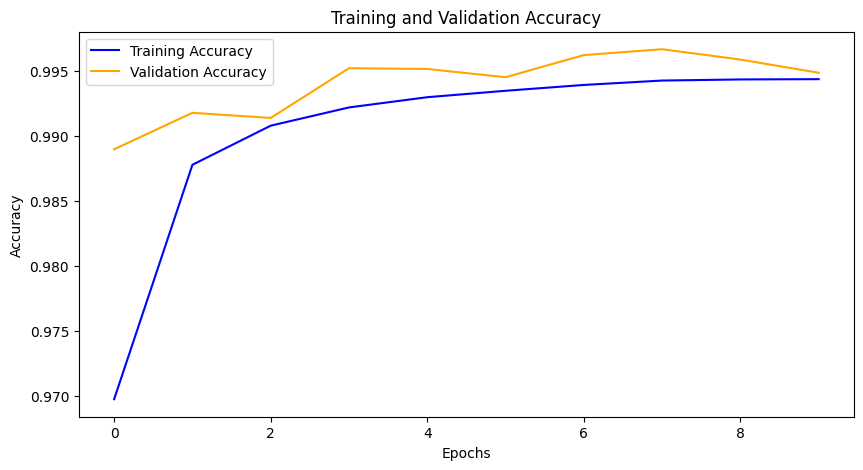

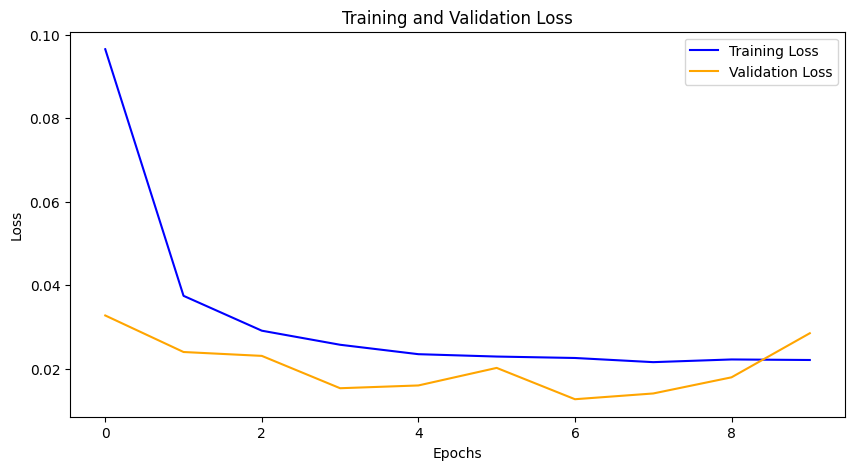

Epoch 1/50
22768/22768 [==============================] - 126s 5ms/step - loss: 0.0987 - accuracy: 0.9690 - val_loss: 0.0357 - val_accuracy: 0.9878
Epoch 2/50
22768/22768 [==============================] - 124s 5ms/step - loss: 0.0407 - accuracy: 0.9866 - val_loss: 0.0227 - val_accuracy: 0.9929
Epoch 3/50
22768/22768 [==============================] - 129s 6ms/step - loss: 0.0315 - accuracy: 0.9899 - val_loss: 0.0274 - val_accuracy: 0.9914
Epoch 4/50
22768/22768 [==============================] - 128s 6ms/step - loss: 0.0274 - accuracy: 0.9916 - val_loss: 0.0122 - val_accuracy: 0.9956
Epoch 5/50
22768/22768 [==============================] - 133s 6ms/step - loss: 0.0249 - accuracy: 0.9925 - val_loss: 0.0232 - val_accuracy: 0.9930
Epoch 6/50
22768/22768 [==============================] - 132s 6ms/step - loss: 0.0226 - accuracy: 0.9933 - val_loss: 0.0166 - val_accuracy: 0.9953
Epoch 7/50
22768/22768 [==============================] - 135s 6ms/step - loss: 0.0228 - accuracy: 0.9936 - val_

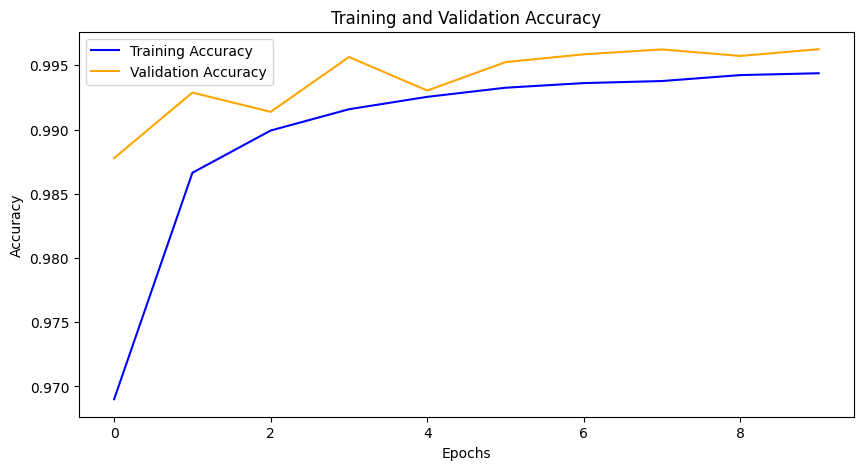

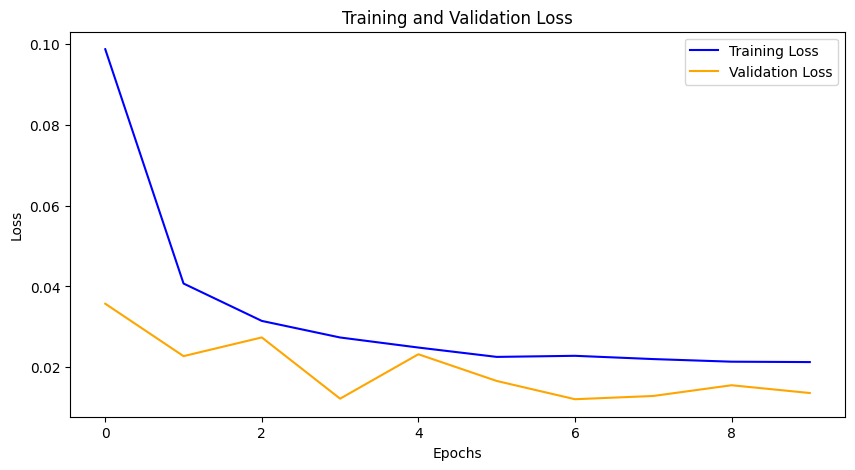

Epoch 1/50
22768/22768 [==============================] - 131s 6ms/step - loss: 0.1001 - accuracy: 0.9689 - val_loss: 0.0394 - val_accuracy: 0.9863
Epoch 2/50
22768/22768 [==============================] - 127s 6ms/step - loss: 0.0408 - accuracy: 0.9868 - val_loss: 0.0223 - val_accuracy: 0.9927
Epoch 3/50
22768/22768 [==============================] - 128s 6ms/step - loss: 0.0315 - accuracy: 0.9901 - val_loss: 0.0164 - val_accuracy: 0.9945
Epoch 4/50
22768/22768 [==============================] - 128s 6ms/step - loss: 0.0275 - accuracy: 0.9916 - val_loss: 0.0188 - val_accuracy: 0.9944
Epoch 5/50
22768/22768 [==============================] - 136s 6ms/step - loss: 0.0243 - accuracy: 0.9926 - val_loss: 0.0181 - val_accuracy: 0.9937
Epoch 6/50
22768/22768 [==============================] - 134s 6ms/step - loss: 0.0233 - accuracy: 0.9931 - val_loss: 0.0179 - val_accuracy: 0.9949


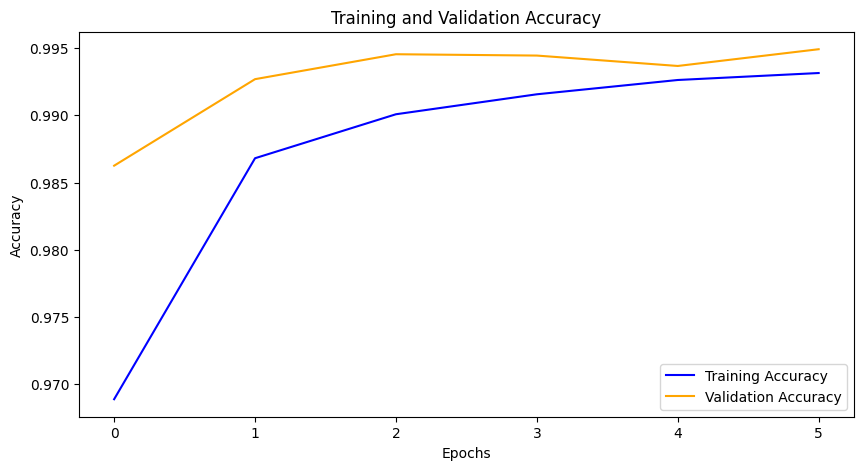

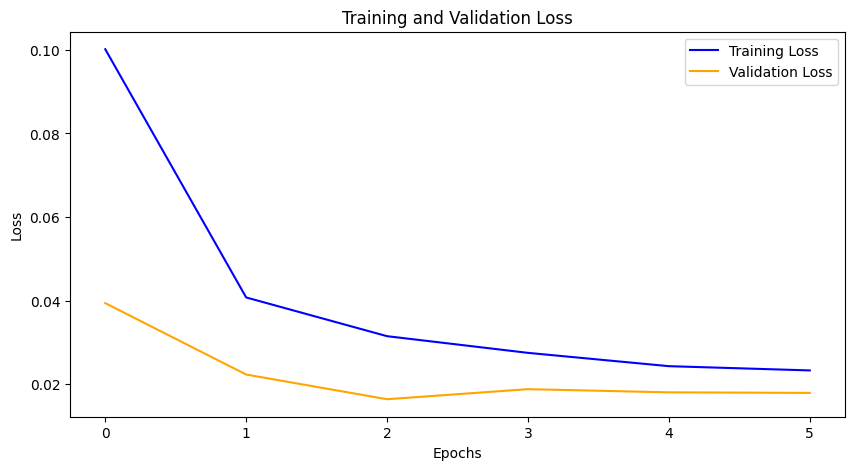

Epoch 1/50
22768/22768 [==============================] - 134s 6ms/step - loss: 0.1004 - accuracy: 0.9684 - val_loss: 0.0595 - val_accuracy: 0.9806
Epoch 2/50
22768/22768 [==============================] - 128s 6ms/step - loss: 0.0425 - accuracy: 0.9861 - val_loss: 0.0257 - val_accuracy: 0.9912
Epoch 3/50
22768/22768 [==============================] - 127s 6ms/step - loss: 0.0328 - accuracy: 0.9894 - val_loss: 0.0280 - val_accuracy: 0.9912
Epoch 4/50
22768/22768 [==============================] - 128s 6ms/step - loss: 0.0273 - accuracy: 0.9913 - val_loss: 0.0171 - val_accuracy: 0.9940
Epoch 5/50
22768/22768 [==============================] - 131s 6ms/step - loss: 0.0255 - accuracy: 0.9924 - val_loss: 0.0120 - val_accuracy: 0.9965
Epoch 6/50
22768/22768 [==============================] - 136s 6ms/step - loss: 0.0243 - accuracy: 0.9930 - val_loss: 0.0138 - val_accuracy: 0.9955
Epoch 7/50
22768/22768 [==============================] - 130s 6ms/step - loss: 0.0218 - accuracy: 0.9936 - val_

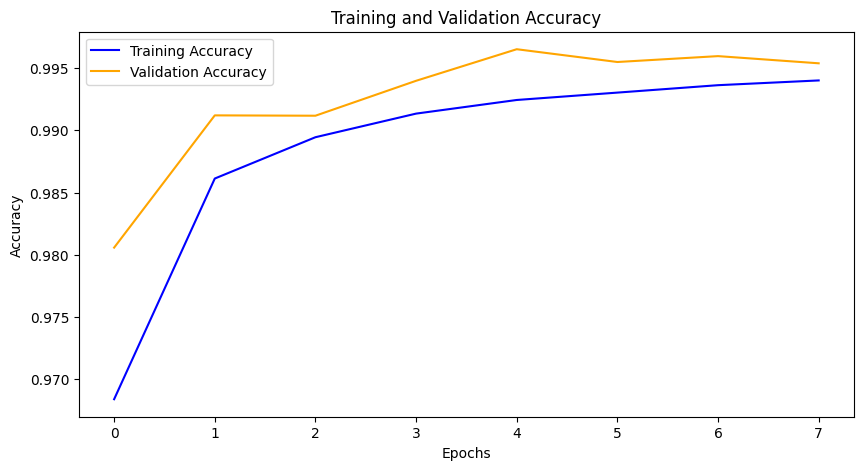

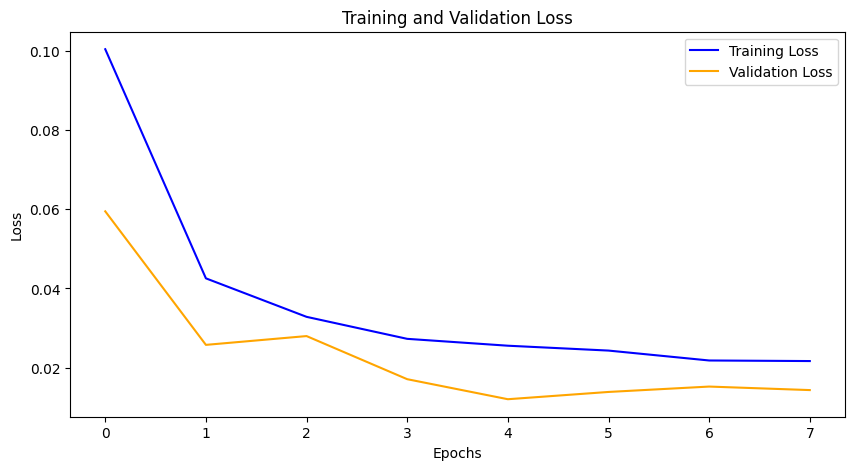

Epoch 1/50
22768/22768 [==============================] - 141s 6ms/step - loss: 0.0978 - accuracy: 0.9694 - val_loss: 0.0305 - val_accuracy: 0.9889
Epoch 2/50
22768/22768 [==============================] - 134s 6ms/step - loss: 0.0389 - accuracy: 0.9873 - val_loss: 0.0228 - val_accuracy: 0.9922
Epoch 3/50
22768/22768 [==============================] - 140s 6ms/step - loss: 0.0295 - accuracy: 0.9905 - val_loss: 0.0182 - val_accuracy: 0.9942
Epoch 4/50
22768/22768 [==============================] - 139s 6ms/step - loss: 0.0264 - accuracy: 0.9918 - val_loss: 0.0228 - val_accuracy: 0.9930
Epoch 5/50
22768/22768 [==============================] - 136s 6ms/step - loss: 0.0247 - accuracy: 0.9928 - val_loss: 0.0161 - val_accuracy: 0.9950
Epoch 6/50
22768/22768 [==============================] - 147s 6ms/step - loss: 0.0227 - accuracy: 0.9934 - val_loss: 0.0191 - val_accuracy: 0.9952
Epoch 7/50
22768/22768 [==============================] - 141s 6ms/step - loss: 0.0216 - accuracy: 0.9940 - val_

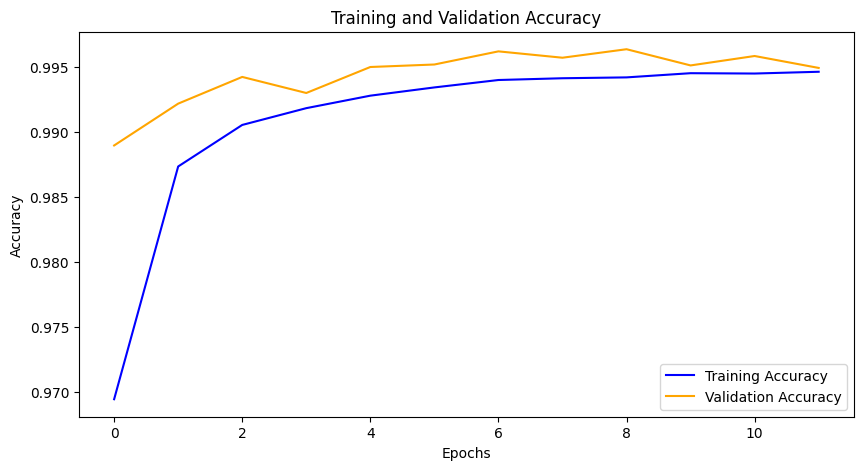

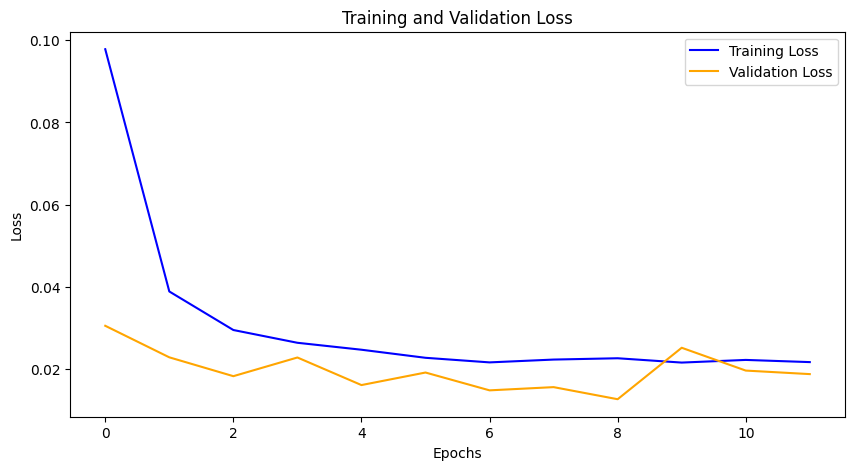

In [ ]:
X = data_to_train[feature_columns].values
y = data_to_train[label_column].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = X.reshape(X.shape[0], X.shape[1], 1)

y_one_hot = to_categorical(y)

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)

all_train_acc, all_val_acc, all_train_loss, all_val_loss = [], [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]

    filters = 128
    size = 7
    pool_size = 2
    dense_neurons = 128

    model = Sequential()
    model.add(Conv1D(filters, size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size))
    model.add(Conv1D(filters, size, activation='relu'))
    model.add(MaxPooling1D(pool_size))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

    all_train_acc.append(history.history['accuracy'])
    all_val_acc.append(history.history['val_accuracy'])
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Training Accuracy', color='blue')
    plt.plot(val_acc, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
model.save('/content/drive/MyDrive/ColabModels/model_kfold_random-patience-3_with-2-separted-subjects-to-train')

In [ ]:
data_to_test.to_csv('/content/drive/MyDrive/ColabData/data_to_test.csv', index=False)

# Non-Optimized Parameters Model


Epoch 1/50
22768/22768 [==============================] - 135s 6ms/step - loss: 0.2322 - accuracy: 0.9263 - val_loss: 0.1106 - val_accuracy: 0.9631
Epoch 2/50
22768/22768 [==============================] - 118s 5ms/step - loss: 0.1227 - accuracy: 0.9597 - val_loss: 0.0822 - val_accuracy: 0.9727
Epoch 3/50
22768/22768 [==============================] - 118s 5ms/step - loss: 0.0998 - accuracy: 0.9671 - val_loss: 0.0702 - val_accuracy: 0.9759
Epoch 4/50
22768/22768 [==============================] - 117s 5ms/step - loss: 0.0866 - accuracy: 0.9710 - val_loss: 0.0570 - val_accuracy: 0.9798
Epoch 5/50
22768/22768 [==============================] - 115s 5ms/step - loss: 0.0774 - accuracy: 0.9739 - val_loss: 0.0508 - val_accuracy: 0.9833
Epoch 6/50
22768/22768 [==============================] - 115s 5ms/step - loss: 0.0709 - accuracy: 0.9763 - val_loss: 0.0552 - val_accuracy: 0.9807
Epoch 7/50
22768/22768 [==============================] - 124s 5ms/step - loss: 0.0657 - accuracy: 0.9776 - val_

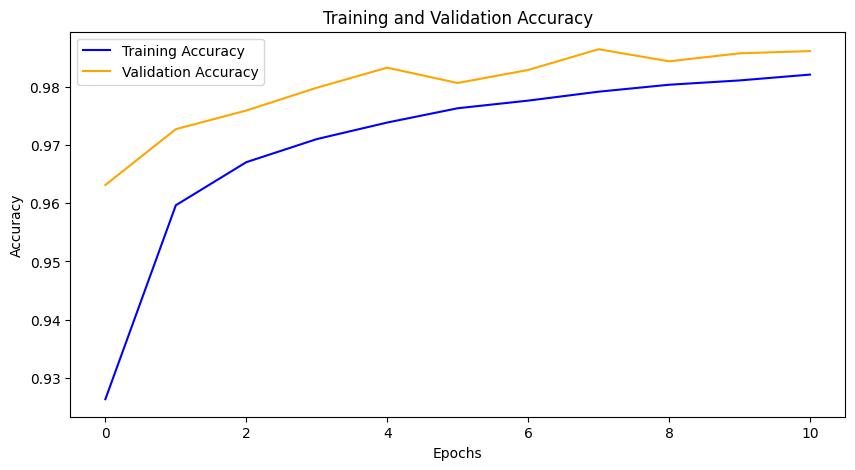

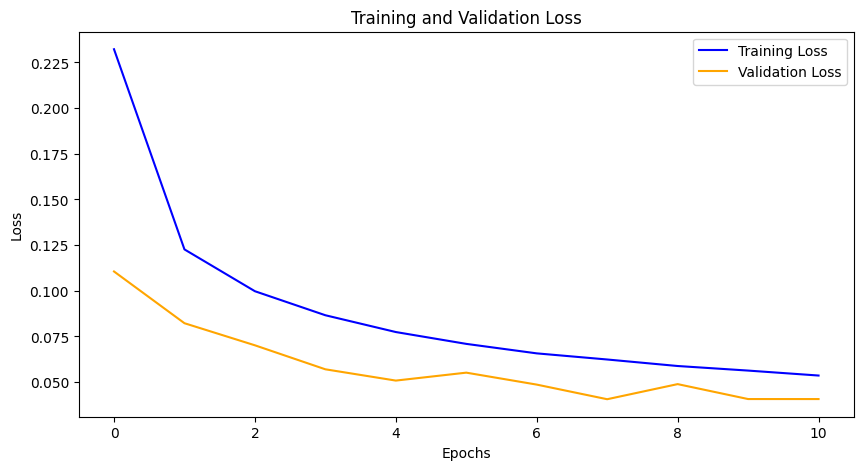

Epoch 1/50
22768/22768 [==============================] - 132s 6ms/step - loss: 0.2216 - accuracy: 0.9294 - val_loss: 0.1010 - val_accuracy: 0.9662
Epoch 2/50
22768/22768 [==============================] - 124s 5ms/step - loss: 0.1187 - accuracy: 0.9611 - val_loss: 0.0816 - val_accuracy: 0.9722
Epoch 3/50
22768/22768 [==============================] - 123s 5ms/step - loss: 0.0956 - accuracy: 0.9683 - val_loss: 0.0702 - val_accuracy: 0.9764
Epoch 4/50
22768/22768 [==============================] - 119s 5ms/step - loss: 0.0836 - accuracy: 0.9720 - val_loss: 0.0586 - val_accuracy: 0.9798
Epoch 5/50
22768/22768 [==============================] - 117s 5ms/step - loss: 0.0745 - accuracy: 0.9752 - val_loss: 0.0506 - val_accuracy: 0.9824
Epoch 6/50
22768/22768 [==============================] - 125s 6ms/step - loss: 0.0681 - accuracy: 0.9773 - val_loss: 0.0476 - val_accuracy: 0.9833
Epoch 7/50
22768/22768 [==============================] - 125s 5ms/step - loss: 0.0641 - accuracy: 0.9785 - val_

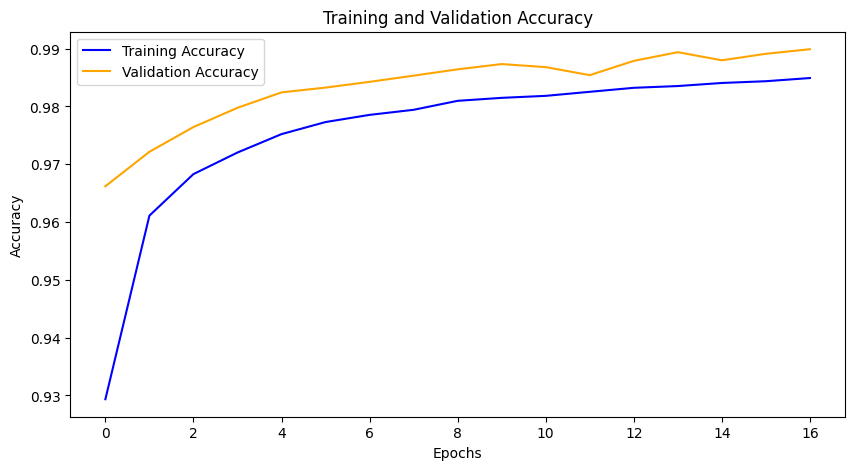

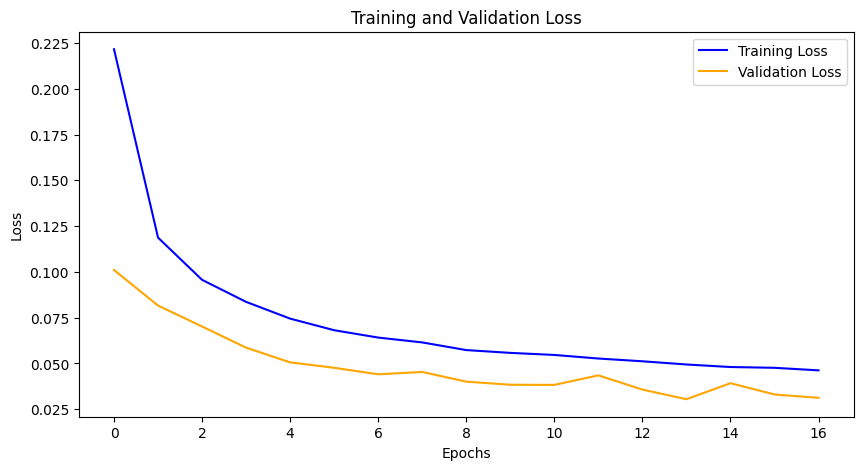

Epoch 1/50
22768/22768 [==============================] - 130s 6ms/step - loss: 0.2265 - accuracy: 0.9277 - val_loss: 0.1089 - val_accuracy: 0.9642
Epoch 2/50
22768/22768 [==============================] - 135s 6ms/step - loss: 0.1223 - accuracy: 0.9603 - val_loss: 0.0822 - val_accuracy: 0.9725
Epoch 3/50
22768/22768 [==============================] - 121s 5ms/step - loss: 0.0998 - accuracy: 0.9672 - val_loss: 0.0745 - val_accuracy: 0.9755
Epoch 4/50
22768/22768 [==============================] - 128s 6ms/step - loss: 0.0870 - accuracy: 0.9713 - val_loss: 0.0603 - val_accuracy: 0.9798
Epoch 5/50
22768/22768 [==============================] - 131s 6ms/step - loss: 0.0791 - accuracy: 0.9739 - val_loss: 0.0565 - val_accuracy: 0.9804
Epoch 6/50
22768/22768 [==============================] - 132s 6ms/step - loss: 0.0730 - accuracy: 0.9758 - val_loss: 0.0532 - val_accuracy: 0.9821
Epoch 7/50
22768/22768 [==============================] - 126s 6ms/step - loss: 0.0689 - accuracy: 0.9772 - val_

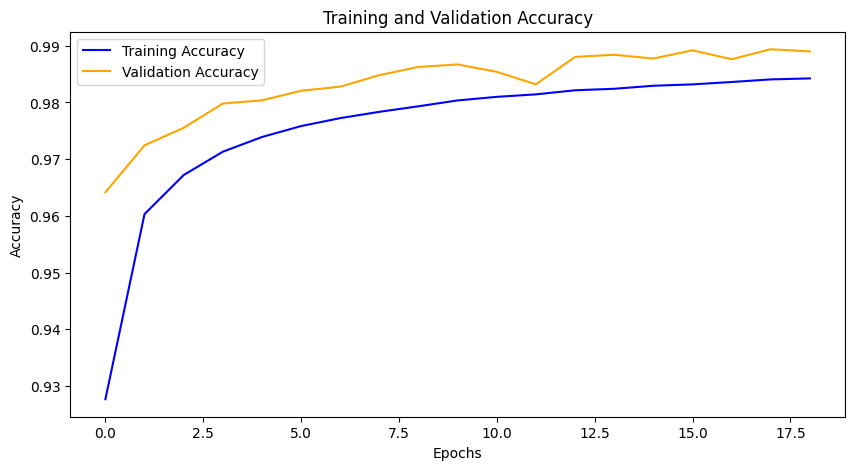

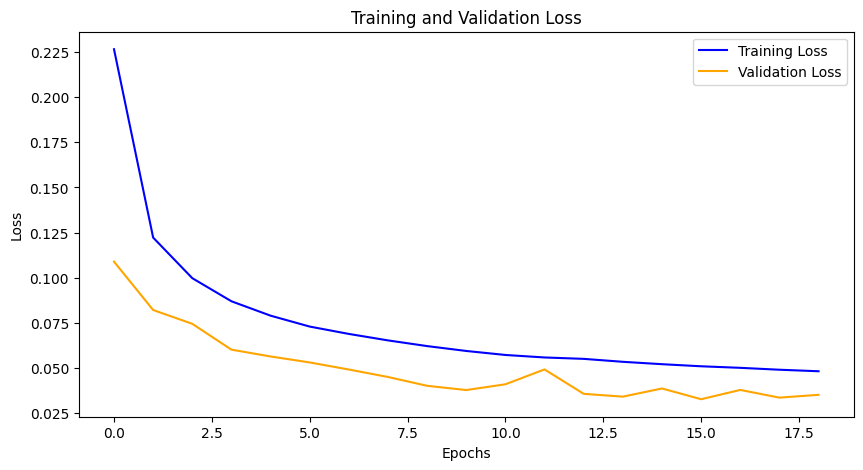

Epoch 1/50
22768/22768 [==============================] - 130s 6ms/step - loss: 0.2219 - accuracy: 0.9296 - val_loss: 0.1142 - val_accuracy: 0.9620
Epoch 2/50
22768/22768 [==============================] - 128s 6ms/step - loss: 0.1189 - accuracy: 0.9611 - val_loss: 0.0773 - val_accuracy: 0.9736
Epoch 3/50
22768/22768 [==============================] - 120s 5ms/step - loss: 0.0968 - accuracy: 0.9679 - val_loss: 0.0703 - val_accuracy: 0.9763
Epoch 4/50
22768/22768 [==============================] - 119s 5ms/step - loss: 0.0847 - accuracy: 0.9720 - val_loss: 0.0600 - val_accuracy: 0.9796
Epoch 5/50
22768/22768 [==============================] - 129s 6ms/step - loss: 0.0770 - accuracy: 0.9746 - val_loss: 0.0516 - val_accuracy: 0.9821
Epoch 6/50
22768/22768 [==============================] - 121s 5ms/step - loss: 0.0709 - accuracy: 0.9764 - val_loss: 0.0528 - val_accuracy: 0.9829
Epoch 7/50
22768/22768 [==============================] - 130s 6ms/step - loss: 0.0654 - accuracy: 0.9783 - val_

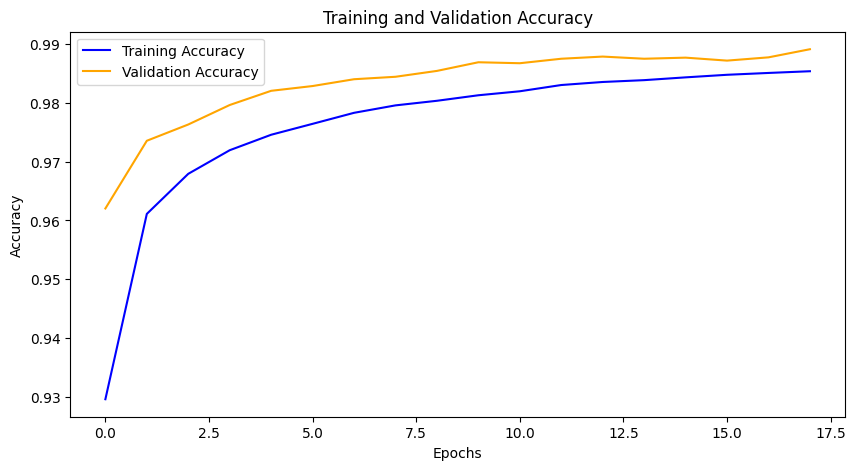

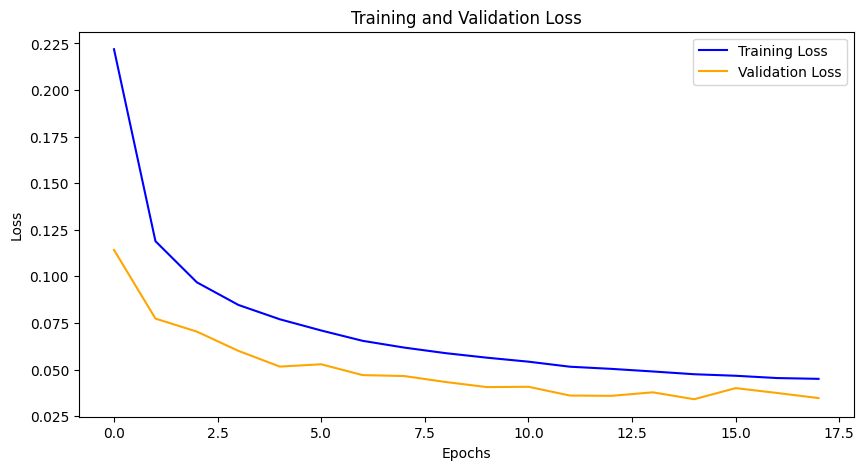

Epoch 1/50
22768/22768 [==============================] - 132s 6ms/step - loss: 0.2306 - accuracy: 0.9261 - val_loss: 0.1256 - val_accuracy: 0.9583
Epoch 2/50
22768/22768 [==============================] - 134s 6ms/step - loss: 0.1257 - accuracy: 0.9585 - val_loss: 0.0838 - val_accuracy: 0.9711
Epoch 3/50
22768/22768 [==============================] - 137s 6ms/step - loss: 0.1015 - accuracy: 0.9663 - val_loss: 0.0749 - val_accuracy: 0.9738
Epoch 4/50
22768/22768 [==============================] - 137s 6ms/step - loss: 0.0891 - accuracy: 0.9701 - val_loss: 0.0624 - val_accuracy: 0.9778
Epoch 5/50
22768/22768 [==============================] - 127s 6ms/step - loss: 0.0816 - accuracy: 0.9728 - val_loss: 0.0547 - val_accuracy: 0.9805
Epoch 6/50
22768/22768 [==============================] - 131s 6ms/step - loss: 0.0752 - accuracy: 0.9748 - val_loss: 0.0545 - val_accuracy: 0.9813
Epoch 7/50
22768/22768 [==============================] - 123s 5ms/step - loss: 0.0702 - accuracy: 0.9764 - val_

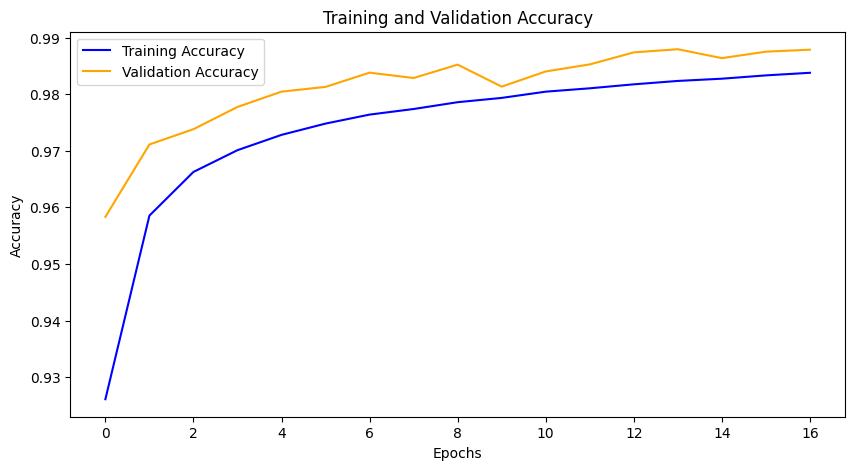

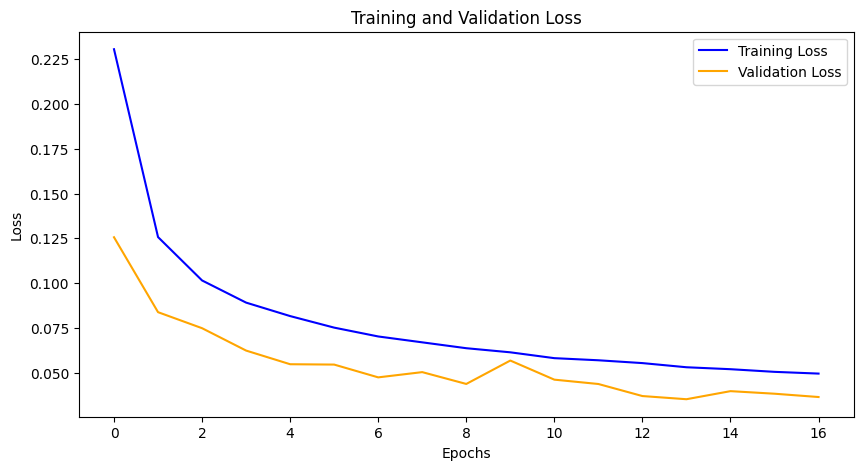

In [7]:
separate_test_data = pd.read_csv('/content/drive/MyDrive/ColabData/data_to_test.csv')

subjects_separete_to_test = separate_test_data['subject_id'].unique()

mask = data['subject_id'].isin(subjects_separete_to_test)
data_to_train = data[~mask].copy()

X = data_to_train[feature_columns].values
y = data_to_train[label_column].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = X.reshape(X.shape[0], X.shape[1], 1)

y_one_hot = to_categorical(y)

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)

all_train_acc, all_val_acc, all_train_loss, all_val_loss = [], [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]

    filters = 64
    size = 3
    pool_size = 2
    dense_neurons = 128

    model = Sequential()
    model.add(Conv1D(filters, size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size))
    model.add(Conv1D(filters, size, activation='relu'))
    model.add(MaxPooling1D(pool_size))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

    all_train_acc.append(history.history['accuracy'])
    all_val_acc.append(history.history['val_accuracy'])
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Training Accuracy', color='blue')
    plt.plot(val_acc, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [8]:
model.save('/content/drive/MyDrive/ColabModels/model_kfold_random-patience-3_with-2-separted-subjects-to-train_non_optimized_params')

# Optimized Parameters Model - Conv Reduced

In [ ]:
separate_test_data = pd.read_csv('/content/drive/MyDrive/ColabData/data_to_test.csv')

subjects_separete_to_test = separate_test_data['subject_id'].unique()

mask = data['subject_id'].isin(subjects_separete_to_test)
data_to_train = data[~mask].copy()

X = data_to_train[feature_columns].values
y = data_to_train[label_column].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X = X.reshape(X.shape[0], X.shape[1], 1)

y_one_hot = to_categorical(y)

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)

all_train_acc, all_val_acc, all_train_loss, all_val_loss = [], [], [], []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]

    filters = 128
    size = 7
    pool_size = 2
    dense_neurons = 128

    model = Sequential()
    model.add(Conv1D(filters, size, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

    all_train_acc.append(history.history['accuracy'])
    all_val_acc.append(history.history['val_accuracy'])
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Training Accuracy', color='blue')
    plt.plot(val_acc, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/5
22768/22768 [==============================] - 147s 6ms/step - loss: 0.4805 - accuracy: 0.8380 - val_loss: 0.3355 - val_accuracy: 0.8832
Epoch 2/5
12122/22768 [==============>...............] - ETA: 56s - loss: 0.3621 - accuracy: 0.8769

In [ ]:
model.save('/content/drive/MyDrive/ColabModels/model_conv_reduced.h5')

# Model Validation - # Optimized Parameters Model

9680/9680 [==============================] - 37s 4ms/step - loss: 1.8572 - accuracy: 0.8430
Optimized Parameters Model - Loss: 1.8571697473526, Accuracy: 0.8430281281471252
9680/9680 [==============================] - 23s 2ms/step
Optimized Parameters Model - Accuracy: 0.8430
Optimized Parameters Model - Precision: 0.8521
Optimized Parameters Model - Recall: 0.8430
Optimized Parameters Model - F1: 0.8397
Optimized Parameters Model - Cohen's Kappa: 0.8109
Optimized Parameters Model - AUC-PR: 0.8561


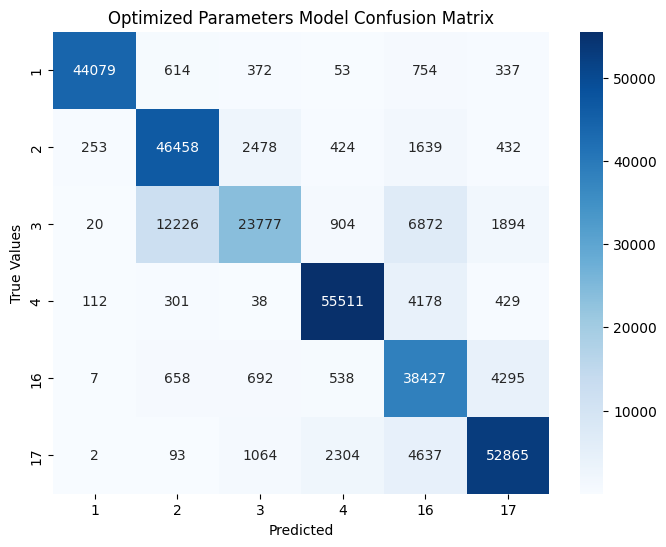

In [24]:
loaded_model = load_model('/content/drive/MyDrive/ColabModels/model_kfold_random-patience-3_with-2-separted-subjects-to-train')

separate_test_data = pd.read_csv('/content/drive/MyDrive/ColabData/data_to_test.csv')

X_separate_test = separate_test_data[feature_columns].values
y_separate_test = separate_test_data[label_column].values


X_separate_test_scaled = scaler.fit_transform(X_separate_test)
X_separate_test_scaled = X_separate_test_scaled.reshape(X_separate_test_scaled.shape[0], X_separate_test_scaled.shape[1], 1)

separate_test_loss, separate_test_accuracy = loaded_model.evaluate(X_separate_test_scaled, to_categorical(y_separate_test))

print(f"Optimized Parameters Model - Loss: {separate_test_loss}, Accuracy: {separate_test_accuracy}")

y_separate_test_pred = loaded_model.predict(X_separate_test_scaled)
y_separate_test_pred_classes = np.argmax(y_separate_test_pred, axis=1)
y_separate_test_one_hot = to_categorical(y_separate_test)

y_separate_test_bin = label_binarize(y_separate_test, classes=np.unique(y_separate_test))
y_separate_test_pred_bin = label_binarize(y_separate_test_pred_classes, classes=np.unique(y_separate_test_pred_classes))

separate_test_accuracy = accuracy_score(y_separate_test, y_separate_test_pred_classes)
separate_test_precision = precision_score(y_separate_test, y_separate_test_pred_classes, average='weighted')
separate_test_recall = recall_score(y_separate_test, y_separate_test_pred_classes, average='weighted')
separate_test_f1 = f1_score(y_separate_test, y_separate_test_pred_classes, average='weighted')
separate_test_cohen_kappa = cohen_kappa_score(y_separate_test, y_separate_test_pred_classes)

ns_cnf_mat= confusion_matrix(y_separate_test, y_separate_test_pred_classes)

separate_test_precision_curve, separate_test_recall_curve, _ = precision_recall_curve(y_separate_test_bin.ravel(), y_separate_test_pred_bin.ravel())
separate_test_pr_auc = auc(separate_test_recall_curve, separate_test_precision_curve)

print(f"Optimized Parameters Model - Accuracy: {separate_test_accuracy:.4f}")
print(f"Optimized Parameters Model - Precision: {separate_test_precision:.4f}")
print(f"Optimized Parameters Model - Recall: {separate_test_recall:.4f}")
print(f"Optimized Parameters Model - F1: {separate_test_f1:.4f}")
print(f"Optimized Parameters Model - Cohen's Kappa: {separate_test_cohen_kappa:.4f}")

print(f"Optimized Parameters Model - AUC-PR: {separate_test_pr_auc:.4f}")

plt.figure(figsize=(8, 6))
categories = valid_activity_ids
sns.heatmap(ns_cnf_mat, annot= True, fmt='g', cmap= 'Blues',
            xticklabels= categories, yticklabels= categories)
plt.title('Optimized Parameters Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True Values')
plt.show()

# Model Validation - # Non-Optimized Parameters Model



9680/9680 [==============================] - 50s 5ms/step - loss: 1.8620 - accuracy: 0.7301
Non-Optimized Parameters Model - Loss: 1.8620258569717407, Accuracy: 0.730145275592804
9680/9680 [==============================] - 25s 3ms/step
Non-Optimized Parameters Model - Accuracy: 0.7301
Non-Optimized Parameters Model - Precision: 0.7849
Non-Optimized Parameters Model - Recall: 0.7301
Non-Optimized Parameters Model - F1: 0.7274
Non-Optimized Parameters Model - Cohen's Kappa: 0.6751
Non-Optimized Parameters Model - AUC-PR: 0.7526


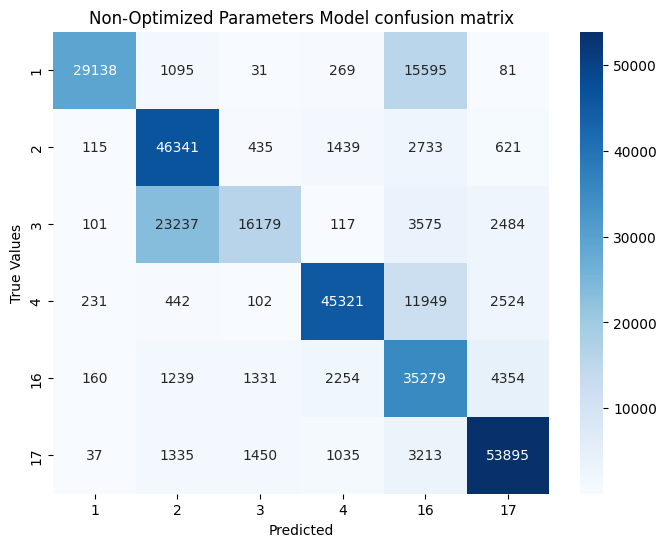

In [23]:
loaded_model = load_model('/content/drive/MyDrive/ColabModels/model_kfold_random-patience-3_with-2-separted-subjects-to-train_non_optimized_params')

separate_test_data = pd.read_csv('/content/drive/MyDrive/ColabData/data_to_test.csv')

X_separate_test = separate_test_data[feature_columns].values
y_separate_test = separate_test_data[label_column].values


X_separate_test_scaled = scaler.fit_transform(X_separate_test)
X_separate_test_scaled = X_separate_test_scaled.reshape(X_separate_test_scaled.shape[0], X_separate_test_scaled.shape[1], 1)

separate_test_loss, separate_test_accuracy = loaded_model.evaluate(X_separate_test_scaled, to_categorical(y_separate_test))

print(f"Non-Optimized Parameters Model - Loss: {separate_test_loss}, Accuracy: {separate_test_accuracy}")

y_separate_test_pred = loaded_model.predict(X_separate_test_scaled)
y_separate_test_pred_classes = np.argmax(y_separate_test_pred, axis=1)
y_separate_test_one_hot = to_categorical(y_separate_test)

y_separate_test_bin = label_binarize(y_separate_test, classes=np.unique(y_separate_test))
y_separate_test_pred_bin = label_binarize(y_separate_test_pred_classes, classes=np.unique(y_separate_test_pred_classes))

separate_test_accuracy = accuracy_score(y_separate_test, y_separate_test_pred_classes)
separate_test_precision = precision_score(y_separate_test, y_separate_test_pred_classes, average='weighted')
separate_test_recall = recall_score(y_separate_test, y_separate_test_pred_classes, average='weighted')
separate_test_f1 = f1_score(y_separate_test, y_separate_test_pred_classes, average='weighted')
separate_test_cohen_kappa = cohen_kappa_score(y_separate_test, y_separate_test_pred_classes)

ns_cnf_mat= confusion_matrix(y_separate_test, y_separate_test_pred_classes)

separate_test_precision_curve, separate_test_recall_curve, _ = precision_recall_curve(y_separate_test_bin.ravel(), y_separate_test_pred_bin.ravel())
separate_test_pr_auc = auc(separate_test_recall_curve, separate_test_precision_curve)

print(f"Non-Optimized Parameters Model - Accuracy: {separate_test_accuracy:.4f}")
print(f"Non-Optimized Parameters Model - Precision: {separate_test_precision:.4f}")
print(f"Non-Optimized Parameters Model - Recall: {separate_test_recall:.4f}")
print(f"Non-Optimized Parameters Model - F1: {separate_test_f1:.4f}")
print(f"Non-Optimized Parameters Model - Cohen's Kappa: {separate_test_cohen_kappa:.4f}")

print(f"Non-Optimized Parameters Model - AUC-PR: {separate_test_pr_auc:.4f}")

plt.figure(figsize=(8, 6))
categories = valid_activity_ids
sns.heatmap(ns_cnf_mat, annot= True, fmt='g', cmap= 'Blues',
            xticklabels= categories, yticklabels= categories)
plt.title('Non-Optimized Parameters Model confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True Values')
plt.show()

# Model Validation - # Optimized Parameters Model - Conv Reduced


In [ ]:
loaded_model = load_model('/content/drive/MyDrive/ColabModels/model_conv_reduced.h5')

separate_test_data = pd.read_csv('/content/drive/MyDrive/ColabData/data_to_test.csv')

X_separate_test = separate_test_data[feature_columns].values
y_separate_test = separate_test_data[label_column].values


X_separate_test_scaled = scaler.fit_transform(X_separate_test)
X_separate_test_scaled = X_separate_test_scaled.reshape(X_separate_test_scaled.shape[0], X_separate_test_scaled.shape[1], 1)

separate_test_loss, separate_test_accuracy = loaded_model.evaluate(X_separate_test_scaled, to_categorical(y_separate_test))

print(f"Early Model - Loss: {separate_test_loss}, Accuracy: {separate_test_accuracy}")

y_separate_test_pred = loaded_model.predict(X_separate_test_scaled)
y_separate_test_pred_classes = np.argmax(y_separate_test_pred, axis=1)
y_separate_test_one_hot = to_categorical(y_separate_test)

y_separate_test_bin = label_binarize(y_separate_test, classes=np.unique(y_separate_test))
y_separate_test_pred_bin = label_binarize(y_separate_test_pred_classes, classes=np.unique(y_separate_test_pred_classes))

separate_test_accuracy = accuracy_score(y_separate_test, y_separate_test_pred_classes)
separate_test_precision = precision_score(y_separate_test, y_separate_test_pred_classes, average='weighted')
separate_test_recall = recall_score(y_separate_test, y_separate_test_pred_classes, average='weighted')
separate_test_f1 = f1_score(y_separate_test, y_separate_test_pred_classes, average='weighted')
separate_test_cohen_kappa = cohen_kappa_score(y_separate_test, y_separate_test_pred_classes)

ns_cnf_mat= confusion_matrix(y_separate_test, y_separate_test_pred_classes)

separate_test_precision_curve, separate_test_recall_curve, _ = precision_recall_curve(y_separate_test_bin.ravel(), y_separate_test_pred_bin.ravel())
separate_test_pr_auc = auc(separate_test_recall_curve, separate_test_precision_curve)

print(f"Early Model - Accuracy: {separate_test_accuracy:.4f}")
print(f"Early Model- Precision: {separate_test_precision:.4f}")
print(f"Early Model - Recall: {separate_test_recall:.4f}")
print(f"Early Model - F1: {separate_test_f1:.4f}")
print(f"Early Model - Cohen's Kappa: {separate_test_cohen_kappa:.4f}")

print(f"Early Model - AUC-PR: {separate_test_pr_auc:.4f}")

plt.figure(figsize=(8, 6))
categories = valid_activity_ids
sns.heatmap(ns_cnf_mat, annot= True, fmt='g', cmap= 'Blues',
            xticklabels= categories, yticklabels= categories)
plt.title('Early Model Confusion Matrix)
plt.xlabel('Predicted')
plt.ylabel('True Values')
plt.show()